In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
# Part A

f = h5py.File('assign2_data2.h5', 'r')
dataKeys = list(f.keys())
print('The data keys are:' + str(dataKeys))

# Gathering the  train images, test images, train labels and test labels.
testdata = np.asarray(f['testx'])
testlbls = np.asarray(f['testd'])
traindata = np.asarray(f['trainx'])
trainlbls = np.asarray(f['traind'])
validdata = np.asarray(f['valx'])
validlbls = np.asarray(f['vald'])
words = np.asarray(f['words'])

print('The size of testdata is: ' + str(np.shape(testdata)))
print('The size of testlbls is: ' + str(np.shape(testlbls)))
print('The size of traindata is: ' + str(np.shape(traindata)))
print('The size of trainlbls is: ' + str(np.shape(trainlbls)))
print('The size of validdata is: ' + str(np.shape(validdata)))
print('The size of validlbls is: ' + str(np.shape(validlbls)))
print('The size of words is: ' + str(np.shape(words)))

The data keys are:['testd', 'testx', 'traind', 'trainx', 'vald', 'valx', 'words']
The size of testdata is: (46500, 3)
The size of testlbls is: (46500,)
The size of traindata is: (372500, 3)
The size of trainlbls is: (372500,)
The size of validdata is: (46500, 3)
The size of validlbls is: (46500,)
The size of words is: (250,)


In [3]:
# One Hot Encode Transform

def one_hot_encoder(x):
    samplesize = np.shape(x)[0]
    x = x.reshape(samplesize,-1)
    featuresize = np.shape(x)[1]
    result = np.zeros((samplesize, featuresize, 250))
    for i in range(samplesize):
        for j in range(featuresize):
            a = x[i,j]
            result[i,j,a-1] = 1
    
    if (featuresize == 1):
        result = result.reshape(-1,250)
    else:
        result = result.reshape(samplesize,250,featuresize)
    return result
        

In [4]:
train_data = one_hot_encoder(traindata)
train_labels = one_hot_encoder(trainlbls)
test_data = one_hot_encoder(testdata)
test_labels = one_hot_encoder(testlbls)
val_data = one_hot_encoder(validdata)
val_labels = one_hot_encoder(validlbls)

print('The size of test_data is: ' + str(np.shape(test_data)))
print('The size of test_labels is: ' + str(np.shape(test_labels)))
print('The size of train_data is: ' + str(np.shape(train_data)))
print('The size of train_labels is: ' + str(np.shape(train_labels)))
print('The size of val_data is: ' + str(np.shape(val_data)))
print('The size of val_labels is: ' + str(np.shape(val_labels)))

The size of test_data is: (46500, 250, 3)
The size of test_labels is: (46500, 250)
The size of train_data is: (372500, 250, 3)
The size of train_labels is: (372500, 250)
The size of val_data is: (46500, 250, 3)
The size of val_labels is: (46500, 250)


In [5]:
class HiddenLayer:
    def __init__(self, neuronNum, neuronSize, mean, std):
        
        '''
        This class creates a hidden laer for neural network. 
        Weights and bias are initially random Gaussian distribution.

        INPUTS:

            neuronNum    : neuronNum is the features a neuron holds.
            neuronSize   : neuronSize is the number of neurons in a hidden layer.
            mean         : mean for Gaussian distribution.
            std          : Standard deviation for Gaussian distribution.

        RETURNS:

        '''         
        
        np.random.seed(8)
        self.weights = np.random.normal( loc=mean, scale=std, size=(neuronNum,neuronSize))
        self.bias = np.random.normal( loc=mean, scale=std, size=(1,neuronSize))
        self.Z = None
        self.A = None
        self.grad = None
        self.dB = None
        self.dW = None
        self.error = None
        self.momentum_dw = 0
        self.momentum_db = 0


In [6]:
class MLP:
    def __init__(self, momentum = False, momentumCoef = 0):
        
        '''
        This class creates a multilayer perceptron network. 

        INPUTS:

            momentum     : momentum is the boolean for the network which indicates 
                           whether the momentum learning will be done or not
                           
            momentumCoef : Coefficient of momentum learning


        RETURNS:

        '''         
        
        self.momentum = momentum
        self.momentumCoef = momentumCoef
        self.layers = list()
        self.batchSize = 0
        
    
    def addLayer(self, layer):
        
        '''
        This function adds a HiddenLayer class to the network. 

        INPUTS:

            layer        : layer is an instance of HiddenLayer class

        RETURNS:

        '''         
        
        self.layers.append(layer)
    
    def sigmoid(self, x):
        
        '''
        This function is the sigmoid for the activation function.
        INPUTS:

            x            : x is the weighted sum which will be pushed to activation function.

        RETURNS:
        
            result       : result is the sigmoid of the input x.
        '''        
        
        result = 1 / (1 + np.exp(-x))
        return result
    
    def der_sigmoid(self, x):
        '''
        This function is the derivative of sigmoid function.
        INPUTS:

            x            : x is the input.

        RETURNS:
        
            result       : result is the derivative of sigmoid of the input x.
        '''         
        
        
        result = self.sigmoid(x) * (1 - self.sigmoid(x))
        return result
    
    def softmax(self, x):
        
        '''
        This function is the softmax for the activation function of output layer.
        INPUTS:

            x            : x is the weighted sum which will be pushed to activation function.

        RETURNS:
        
            result       : result is the softmax of the input x.
        '''         
        
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        result = e_x / np.sum(e_x, axis=-1, keepdims=True)
        return result
    
    def der_softmax(self, x):
        
        '''
        This function is the derivative of softmax.
        INPUTS:

            x            : x is the input.

        RETURNS:
        
            result       : result is the derivative of softmax of the input x.
        '''           
        
        p = self.softmax(x)
        result = p * (1-p)
        return result
    
    def we(self, x):
        
        '''
        This function is the word embedding layer's activation function.
        INPUTS:

            x            : x is the weighted sum which will be pushed to activation function.

        RETURNS:
        
            result       : result is the x itself.
        '''           
        
        return x
    
    def der_we(self, x):
        '''
        This function is the derivative of word embedding layer's activation function.
        INPUTS:

            x            : x is input.

        RETURNS:
        
            result       : result is an array of ones with x's shape..
        '''                
        
        
        return np.ones(x.shape)
    
    def cross_entropy(self, y, y_pred):
        
        '''
        cross_entropy is the loss function for the network. 
        INPUTS:

            y            : y is the labels for our data.
            y_pred       : y_pred is the network's prediction.

        RETURNS:
        
            cost         : cost is the cross entropy error between y and y_pred.
        '''         
        
        # To avoid 0
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        
        cost = -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
        return cost
    
    def der_cross_entropy(self, y, y_pred):
        '''
        der_cross_entropy is the derivative of loss function for the network. 
        INPUTS:

            y            : y is the labels for our data.
            y_pred       : y_pred is the network's prediction.

        RETURNS:
        
                         : returns the derivative of cross entropy error between y and y_pred.
        '''            
        
        # To avoid division by 0.
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        
        return - (y / y_pred) + (1 - y) / (1 - y_pred)
        
    def forward(self, data):
        
        '''
        forward function is the forward propagation.
        INPUTS:

            data         : data is the input which will pushed to forward propagation.

        RETURNS:
        
                         : returns the prediction of the network.
        '''         
        
        layerSize = np.shape(self.layers)[0]
        for i in range(layerSize):
            # Output Layer
            if (i == layerSize - 1):
                self.layers[i].A = (self.layers[i-1].Z).dot(self.layers[i].weights) + self.layers[i].bias
                self.layers[i].Z = self.softmax(self.layers[i].A)
            # 1st Hidden Layer
            if (i == 0):
                self.layers[i].A = data.dot(self.layers[i].weights) + self.layers[i].bias
                self.layers[i].Z = self.we(self.layers[i].A)
            # Other Hidden Layers
            else:
                self.layers[i].A = (self.layers[i-1].Z).dot(self.layers[i].weights) + self.layers[i].bias
                self.layers[i].Z = self.sigmoid(self.layers[i].A)
    
        return self.layers[-1].Z
    
                
    def back_propagation(self, data, label):
        
        '''
        back_propagation function is the back propagation algorithm for weight and bias updates.
        back_propagation function first calls forward function to predict the output of network which us y_pred.
        INPUTS:

            data         : data is the input.
            label        : label is the labels of the data.

        RETURNS:
        
        '''           
        
        layerSize = np.shape(self.layers)[0]
        y_pred = self.forward(data)

        for i in range(layerSize)[::-1]:
            # Output Layer
            if (i == layerSize - 1):
                self.layers[i].error = self.der_cross_entropy(label, y_pred)
                self.layers[i].grad = (self.layers[i].error) * (self.der_softmax(self.layers[i].A))
                self.layers[i].dW = (self.layers[i-1].Z).T.dot(self.layers[i].grad)
                self.layers[i].dB = np.sum(self.layers[i].grad, axis=0, keepdims=True)
                
            # 1st Hidden Layer
            elif(i == 0):
                self.layers[i].error = (self.layers[i+1].grad).dot(self.layers[i+1].weights.T)
                self.layers[i].grad = (self.layers[i].error) * self.der_we(self.layers[i].A)
                self.layers[i].dW = data.T.dot(self.layers[i].grad)
                self.layers[i].dB = np.sum(self.layers[i].grad, axis=0, keepdims=True)
            
            # Other Layers
            else:
                self.layers[i].error = (self.layers[i+1].grad).dot(self.layers[i+1].weights.T)
            
                self.layers[i].grad = (self.layers[i].error) * self.der_sigmoid(self.layers[i].A)
                self.layers[i].dW = (self.layers[i-1].Z).T.dot(self.layers[i].grad)
                self.layers[i].dB = np.sum(self.layers[i].grad, axis=0, keepdims=True)
            
    
    def update_weights(self, data, label, learningRate):
        
        '''
        update_weights function updates the weights with the gradients found with back_propagation.
        INPUTS:

            data         : data is the input.
            label        : label is the labels of the data.
            learnigRate  : learningRate is the coefficient for the weight update.

        RETURNS:
        
        '''         
        
        layerSize = np.shape(self.layers)[0]
        self.back_propagation(data,label)
        
        # If momentum is used.
        if( self.momentum == True ):
            for i in range(layerSize):
                
                self.layers[i].momentum_dw = self.layers[i].dW + (self.momentumCoef * self.layers[i].momentum_dw)
                self.layers[i].momentum_db = self.layers[i].dB + (self.momentumCoef * self.layers[i].momentum_db)

                self.layers[i].weights -= (learningRate * self.layers[i].momentum_dw)/self.batchSize
                self.layers[i].bias -= (learningRate * self.layers[i].momentum_db)/self.batchSize
                
        # If momentum is not used.        
        else:
            for i in range(layerSize):  

                self.layers[i].weights -= (learningRate * self.layers[i].dW)/self.batchSize
                self.layers[i].bias -= (learningRate * self.layers[i].dB)/self.batchSize
            
    
    def predict(self, y_pred):
        
        '''
        predict function predicts and output from the network's output y_pred.
        INPUTS:

            y_pred       : MLP's output.

        RETURNS:
        
                         : returns the label for prediction of the network.
        '''          
        
        word = np.argmax(y_pred, axis=-1)
        return word
    
    def accuracy(self, y, y_pred):
        
        '''
        accuracy function is the accuracy of our network.
        INPUTS:

            y            : y is the labels for our data.
            y_pred       : y_pred is the network's prediction.

        RETURNS:
        
                         : returns the accuracy between y and y_pred.
        '''          
        
        count = 0
        
        y_words = np.argmax(y, axis=-1)
        y_pred_words = self.predict(y_pred)
        for i in range(len(y_words)):
            if(y_words[i] == y_pred_words[i]):
                count += 1
        return 100 * (count / len(y_words))
    
    def predict_10(self, y, y_pred,k,seed):
        
        '''
        predict_10 function lists the top 10 candidates for the selected triagram.
        INPUTS:

            y            : y is the labels for our data.
            y_pred       : y_pred is the network's prediction.
            k            : K is the number of predictions.
            seed         : For the random initialization.
            
        RETURNS:
        
            indeces           : indeces is the indeces of the selected 5 samples.
            indeces_test      : indeces_test is the labels of the selected 5 sampled from test data.
            indeces_test_pred : indeces_test_pred is the prediction of the network for the selected 5 samples
                                from the test data.
        '''          
        
        np.random.seed(seed)
        indeces = np.random.randint(250, size=5)
        y_new = y[indeces]
        y_pred_new = y_pred[indeces]
        indeces_test_pred = list()
        indeces_test = list()
        
        for i in range(np.shape(y_pred_new)[0]):
            indeces_test.append(np.argmax(y[i], axis=-1))
            indeces_test_pred.append(np.argpartition(y_pred_new[i], -k, axis=-1)[-k:])
        
        return indeces, indeces_test, indeces_test_pred
    
    def trainNetwork(self, data, label, validData, validLabel, learningRate, batchNum, epoch):
        
        '''
        trainNetwork function calls the update_weights function to train the network over mini-batches
        for fiven number of epochs.
        INPUTS:

            data         : data is the training data.
            label        : label is the labels of the data.
            validData    : validData is the valid data.
            validLabel   : validLabel is the labels of the validData.
            learningRate : learningRate is the coefficient for the weight update.
            batchNum     : batchNum is the number of mini-batches.
            epoch        : Number of times the network train the whole data.

        RETURNS:
        
            cost         : Cross entropy error over epochs on test data.
            accuracies   : Accuracies over epochs on test data.

        '''        
        
        cost = list()
        accuracies = list()
        
        np.random.seed(7)
        
        for i in range(epoch):
            randomIndexes = np.random.permutation(len(label)) 
            data = data[randomIndexes] 
            label = label[randomIndexes]
            
            batchLength = len(label) / batchNum
            self.batchSize = batchLength
            for j in range(batchNum):

                start = int(batchLength*j)
                end = int(batchLength*(j+1))
                self.update_weights(data[start:end],label[start:end],learningRate)
            
            y_pred = self.forward(validData)
            cross_entropy_cost = self.cross_entropy(validLabel, y_pred)
            cost.append(cross_entropy_cost)
            
            
            accuracy = self.accuracy(validLabel, y_pred)
            accuracies.append(accuracy)
    
            
        return cost, accuracies

In [7]:
D = 8
P = 64

neuralNet0 = MLP(momentum = True, momentumCoef = 0.85)
neuralNet0.addLayer(HiddenLayer(250, D, 0, 0.01)) 
neuralNet0.addLayer(HiddenLayer(D, P, 0, 0.01))
neuralNet0.addLayer(HiddenLayer(P, 250, 0, 0.01)) 

train_data_1H = np.sum(train_data, axis=-1)
val_data_1H = np.sum(val_data, axis=-1)

cost0, accuracy0 = neuralNet0.trainNetwork(train_data_1H, train_labels, val_data_1H, val_labels, 0.15, 1490, 50)

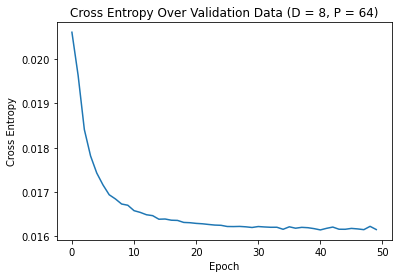

In [8]:
figureNum = 0
plt.figure(figureNum)
plt.title('Cross Entropy Over Validation Data (D = 8, P = 64)')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(cost0)
plt.show()

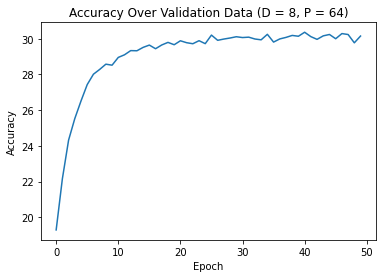

In [9]:
figureNum += 1
plt.figure(figureNum)
plt.title('Accuracy Over Validation Data (D = 8, P = 64)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy0)
plt.show()

In [10]:
D = 16
P = 128

neuralNet1 = MLP(momentum = True, momentumCoef = 0.85)
neuralNet1.addLayer(HiddenLayer(250, D, 0, 0.01)) 
neuralNet1.addLayer(HiddenLayer(D, P, 0, 0.01))
neuralNet1.addLayer(HiddenLayer(P, 250, 0, 0.01)) 

train_data_1H = np.sum(train_data, axis=-1)
val_data_1H = np.sum(val_data, axis=-1)

cost1, accuracy1 = neuralNet1.trainNetwork(train_data_1H, train_labels, val_data_1H, val_labels, 0.15, 1490, 50)

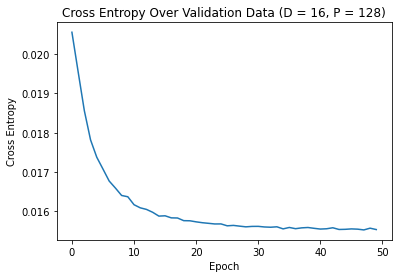

In [11]:
figureNum += 1
plt.figure(figureNum)
plt.title('Cross Entropy Over Validation Data (D = 16, P = 128)')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(cost1)
plt.show()

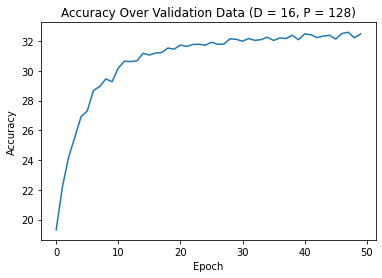

In [12]:
figureNum += 1
plt.figure(figureNum)
plt.title('Accuracy Over Validation Data (D = 16, P = 128)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy1)
plt.show()

In [13]:
D = 32
P = 256

neuralNet2 = MLP(momentum = True, momentumCoef = 0.85)
neuralNet2.addLayer(HiddenLayer(250, D, 0, 0.01)) 
neuralNet2.addLayer(HiddenLayer(D, P, 0, 0.01))
neuralNet2.addLayer(HiddenLayer(P, 250, 0, 0.01)) 

train_data_1H = np.sum(train_data, axis=-1)
val_data_1H = np.sum(val_data, axis=-1)

cost2, accuracy2 = neuralNet2.trainNetwork(train_data_1H, train_labels, val_data_1H, val_labels, 0.15, 1490, 50)

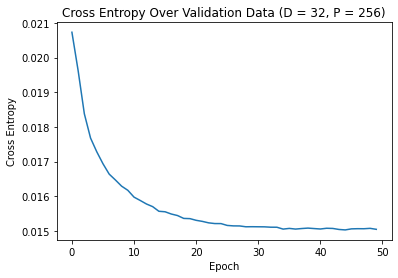

In [14]:
figureNum += 1
plt.figure(figureNum)
plt.title('Cross Entropy Over Validation Data (D = 32, P = 256)')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(cost2)
plt.show()

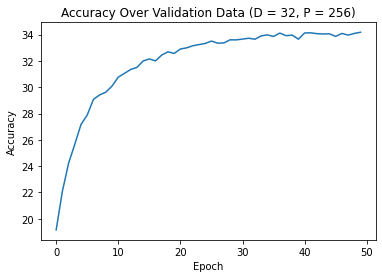

In [15]:
figureNum += 1
plt.figure(figureNum)
plt.title('Accuracy Over Validation Data (D = 32, P = 256)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy2)
plt.show()

In [16]:
# Part B

test_data_1H = np.sum(test_data, axis=-1)

random_indeces, indeces_test, indeces_test_pred = neuralNet2.predict_10(test_labels, neuralNet2.forward(test_data_1H), 10, 6)

In [17]:
indeces_test_pred = np.asarray(indeces_test_pred)
three_words = testdata[random_indeces]
the_label = testlbls[random_indeces]

three_words[:] -= 1
the_label[:] -= 1

words_test_pred = list()
for i in range (np.shape(indeces_test_pred)[0]):
    words_test_pred.append(words[indeces_test_pred[i]])


for i in range(np.shape(words_test_pred)[0]):
    ws = [w.decode('UTF-8') for w in words[three_words[i]]]
    print('\033[0m' + "Words are: \033[1m {}".format(ws))
    print('\033[0m' +'The 4th word is : ' + '\033[1m' +str(words[the_label[i]].decode('utf-8')))
    print('\033[0m' + 'The predicted top 10 words are: ')
    pred_ws = [words_test_pred[i][j].decode('UTF-8') for j in range(np.shape(words_test_pred)[1])]

    print( '\033[1m' + str(pred_ws))
    print('\n')
    

Words are:  ['for', 'long', ',']
The 4th word is : he
The predicted top 10 words are: 
['you', 'a', 'but', 'they', 'long', 'he', 'she', 'though', 'it', 'i']


Words are:  ['i', 'do', 'not']
The 4th word is : think
The predicted top 10 words are: 
['be', 'do', 'like', ',', 'know', 'think', '.', 'want', '?', 'have']


Words are:  ['not', 'that', 'these']
The 4th word is : people
The predicted top 10 words are: 
['has', 'would', 'does', '.', 'was', 'did', 'had', 'could', 'years', 'people']


Words are:  ['could', 'you', 'not']
The 4th word is : like
The predicted top 10 words are: 
['come', 'do', 'want', ',', 'know', '.', 'think', 'like', 'be', '?']


Words are:  ['know', 'who', 'these']
The 4th word is : people
The predicted top 10 words are: 
['says', "'s", 'will', 'did', 'people', 'are', 'is', 'does', 'was', 'can']


